# Training and visualization

In [93]:
from secml.array import CArray
from secml.data.loader import CDLRandom
from secml.data.splitter import CDataSplitter
from secml.figure import CFigure
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
from secml.ml.features import CNormalizer, CNormalizerMinMax
from secml.ml.kernel import CKernelRBF, CKernel
from secml.ml.peval import CPerfEvaluatorXVal
from secml.ml.peval.metrics import CMetric

In [102]:
random_state = 2134
n_classes = 3
n_features = 2
n_tr = 1000
n_ts = 200
lb = 0.0
ub = 1.0

dataset = CDLRandom(n_classes=n_classes, n_features=n_features, n_informative=n_features, n_redundant=0,
                    n_samples=n_tr+n_ts,
                    n_clusters_per_class=1, class_sep=2,
                    random_state=random_state).load()

idx = CArray.arange(0, dataset.num_samples)

idx.shuffle()
tr = dataset[n_tr:, :]
ts = dataset[:n_ts, :]

# Normalize the data
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X, tr.Y)
ts.X = nmz.transform(ts.X)

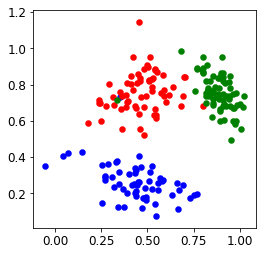

In [103]:
figure = CFigure(width=4, height=4)
colors = list("brgyk")
for c in range(n_classes):
    figure.sp.scatter(ts.X[ts.Y==c, 0], ts.X[ts.Y==c, 1], c=colors[c])
figure.show()

In [108]:
kernel = CKernel.create('rbf')
multiclass = CClassifierMulticlassOVA(
    CClassifierSVM, C=1, kernel=kernel)

xval_params = {'C': [1, 10, 100], 'kernel.gamma': [0.1, 1]}

In [109]:
xval_splitter = CDataSplitter.create(
            'kfold', num_folds=3, random_state=50000)
best_params = multiclass.estimate_parameters(
            tr, xval_params, xval_splitter, 'accuracy',
            perf_evaluator='xval-multiclass', n_jobs=1)

print(best_params)

# set best parameters and fit
multiclass.set_params(best_params)
multiclass.fit(tr)

perf_eval = CPerfEvaluatorXVal(
        xval_splitter, CMetric.create('accuracy'))
print(perf_eval.compute_performance(multiclass, ts))

{'C': (1, 10, 1), 'kernel.gamma': (0.1, 1, 1)}
0.9699231117141566


In [ ]:
# plot decision function